# XGBoost Training - Model Dataset with ROC Analysis


## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, ParameterSampler
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc
)

from xgboost import XGBClassifier
from tqdm.auto import tqdm

import joblib
from datetime import datetime
from itertools import cycle

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 2. Load Data

In [2]:
df = pd.read_csv('model_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['facility_rating_status'].value_counts())
print(f"\nClass percentages:")
print(df['facility_rating_status'].value_counts(normalize=True) * 100)

Dataset shape: (65504, 59)

Target distribution:
facility_rating_status
0    55693
1     6711
2     3100
Name: count, dtype: int64

Class percentages:
facility_rating_status
0    85.022289
1    10.245176
2     4.732535
Name: proportion, dtype: float64


## 3. Prepare Features and Target

In [3]:
X = df.drop('facility_rating_status', axis=1)
y = df['facility_rating_status']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns: {X.shape[1]}")

Features shape: (65504, 58)
Target shape: (65504,)

Feature columns: 58


## 4. Train-Validation Split

In [4]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nValidation target distribution:")
print(y_val.value_counts())

Training set: (52403, 58)
Validation set: (13101, 58)

Training target distribution:
facility_rating_status
0    44554
1     5369
2     2480
Name: count, dtype: int64

Validation target distribution:
facility_rating_status
0    11139
1     1342
2      620
Name: count, dtype: int64


## 5. Scale Features

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("Features scaled using StandardScaler")

Features scaled using StandardScaler


## 6. Calculate Class Weights

In [6]:
class_counts = y_train.value_counts().sort_index()
total = len(y_train)
n_classes = len(class_counts)

class_weights = {}
for cls in class_counts.index:
    class_weights[cls] = total / (n_classes * class_counts[cls])

print("Class weights:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")

Class weights:
  Class 0: 0.3921
  Class 1: 3.2534
  Class 2: 7.0434


## 7. Baseline Model

In [7]:
xgb_baseline = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_baseline.fit(X_train_scaled, y_train)

y_pred = xgb_baseline.predict(X_val_scaled)
baseline_accuracy = accuracy_score(y_val, y_pred)

print(f"Baseline Validation Accuracy: {baseline_accuracy:.4f}")

Baseline Validation Accuracy: 0.9515


## 8. Hyperparameter Tuning

In [8]:
param_distributions = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3]
}

n_iter = 20
param_list = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=42))

best_score = 0
best_params = None

print(f"\nTesting {n_iter} parameter combinations...\n")

for i, params in enumerate(tqdm(param_list, desc="Hyperparameter Search")):
    xgb = XGBClassifier(
        **params,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    scores = cross_val_score(xgb, X_train_scaled, y_train, cv=3, scoring='accuracy')
    mean_score = scores.mean()
    
    if mean_score > best_score:
        best_score = mean_score
        best_params = params

print(f"\nBest cross-validation score: {best_score:.4f}")
print(f"\nBest parameters:")
for param, value in best_params.items():
    print(f"  {param}: {value}")


Testing 20 parameter combinations...



Hyperparameter Search:   0%|          | 0/20 [00:00<?, ?it/s]


Best cross-validation score: 0.9525

Best parameters:
  subsample: 0.9
  n_estimators: 100
  min_child_weight: 5
  max_depth: 5
  learning_rate: 0.05
  gamma: 0.1
  colsample_bytree: 0.9


## 9. Train Final Model

In [9]:
xgb_tuned = XGBClassifier(
    **best_params,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

xgb_tuned.fit(X_train_scaled, y_train)

print("Final model trained successfully")

Final model trained successfully


## 10. Validation Results

In [10]:
y_pred_tuned = xgb_tuned.predict(X_val_scaled)
tuned_accuracy = accuracy_score(y_val, y_pred_tuned)

print("="*70)
print("VALIDATION RESULTS")
print("="*70)
print(f"\nBaseline Accuracy: {baseline_accuracy:.4f}")
print(f"Tuned Accuracy:    {tuned_accuracy:.4f}")
print(f"Improvement:       {(tuned_accuracy - baseline_accuracy):.4f}")

print(f"\n{'='*70}")
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_val, y_pred_tuned, 
                          target_names=['Class 0', 'Class 1', 'Class 2']))

print(f"\n{'='*70}")
print("CONFUSION MATRIX")
print("="*70)
cm = confusion_matrix(y_val, y_pred_tuned)
print(cm)

VALIDATION RESULTS

Baseline Accuracy: 0.9515
Tuned Accuracy:    0.9515
Improvement:       -0.0001

CLASSIFICATION REPORT
              precision    recall  f1-score   support

     Class 0       0.95      1.00      0.97     11139
     Class 1       0.98      0.71      0.82      1342
     Class 2       0.98      0.64      0.77       620

    accuracy                           0.95     13101
   macro avg       0.97      0.78      0.86     13101
weighted avg       0.95      0.95      0.95     13101


CONFUSION MATRIX
[[11119    14     6]
 [  391   950     1]
 [  223     1   396]]


## 11. ROC-AUC Analysis (Multiclass)

In [11]:
# Get predicted probabilities for all classes
y_proba = xgb_tuned.predict_proba(X_val_scaled)

# Binarize the output for One-vs-Rest ROC
y_val_bin = label_binarize(y_val, classes=[0, 1, 2])
n_classes = y_val_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_bin.ravel(), y_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print("="*70)
print("ROC-AUC SCORES (One-vs-Rest)")
print("="*70)
print(f"\nPer-Class ROC-AUC:")
for i in range(n_classes):
    print(f"  Class {i}: {roc_auc[i]:.4f}")

print(f"\nAveraged ROC-AUC:")
print(f"  Micro-average: {roc_auc['micro']:.4f}")
print(f"  Macro-average: {roc_auc['macro']:.4f}")

# Calculate weighted average based on class distribution
class_weights_eval = y_val.value_counts(normalize=True).sort_index().values
weighted_auc = sum(roc_auc[i] * class_weights_eval[i] for i in range(n_classes))
print(f"  Weighted-average: {weighted_auc:.4f}")

ROC-AUC SCORES (One-vs-Rest)

Per-Class ROC-AUC:
  Class 0: 0.9290
  Class 1: 0.9311
  Class 2: 0.9284

Averaged ROC-AUC:
  Micro-average: 0.9842
  Macro-average: 0.9295
  Weighted-average: 0.9292


## 12. ROC Curve Visualization

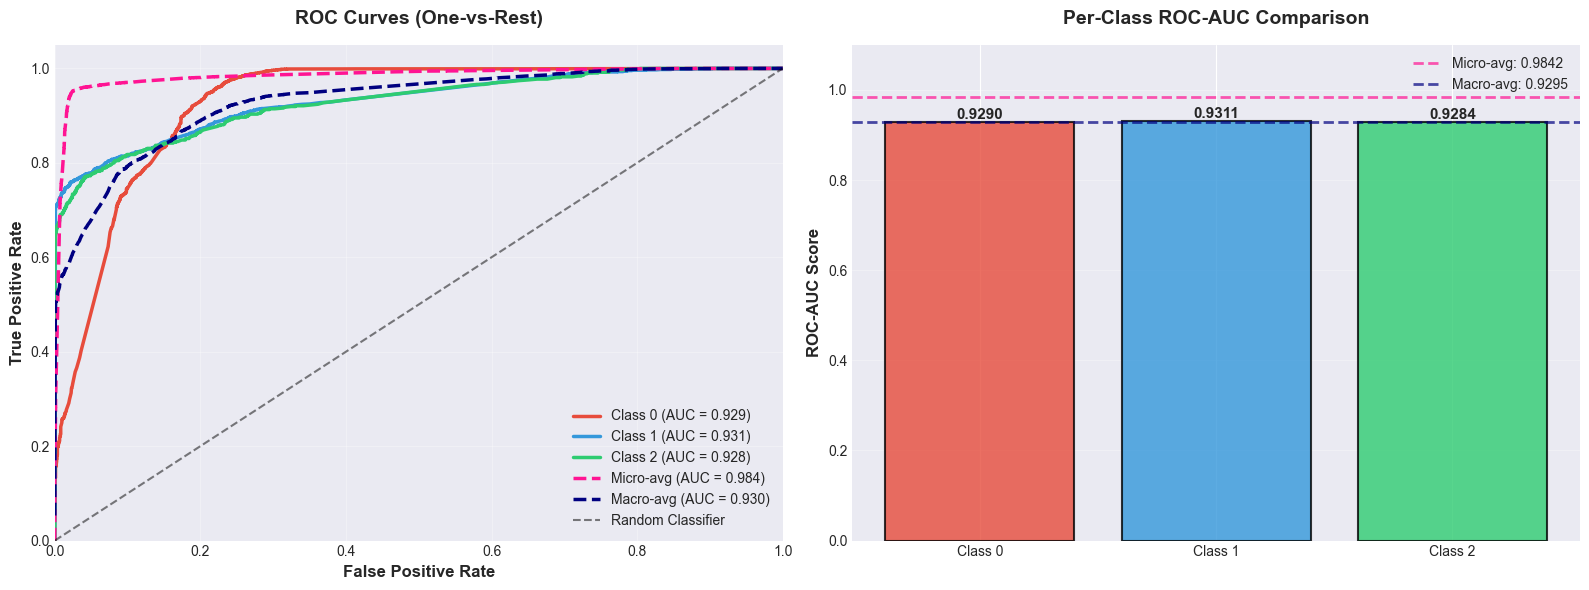


ROC curve visualization saved as 'ROC_Analysis.png'


In [13]:
# Create comprehensive ROC curve plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: All ROC curves together
colors = cycle(['#e74c3c', '#3498db', '#2ecc71', '#9b59b6', '#f39c12'])

# Plot individual class ROC curves
for i, color in zip(range(n_classes), colors):
    ax1.plot(
        fpr[i], tpr[i], 
        color=color, 
        lw=2.5,
        label=f'Class {i} (AUC = {roc_auc[i]:.3f})'
    )

# Plot micro-average
ax1.plot(
    fpr["micro"], tpr["micro"],
    color='deeppink', 
    linestyle='--', 
    lw=2.5,
    label=f'Micro-avg (AUC = {roc_auc["micro"]:.3f})'
)

# Plot macro-average
ax1.plot(
    fpr["macro"], tpr["macro"],
    color='navy', 
    linestyle='--', 
    lw=2.5,
    label=f'Macro-avg (AUC = {roc_auc["macro"]:.3f})'
)

# Plot diagonal reference line
ax1.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random Classifier')

ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold', pad=15)
ax1.legend(loc="lower right", fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3)

# Plot 2: Per-class comparison bar chart
classes = [f'Class {i}' for i in range(n_classes)]
auc_scores = [roc_auc[i] for i in range(n_classes)]
colors_bar = ['#e74c3c', '#3498db', '#2ecc71']

bars = ax2.bar(classes, auc_scores, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width()/2., height,
        f'{score:.4f}',
        ha='center', va='bottom', 
        fontsize=11, fontweight='bold'
    )

# Add horizontal lines for averaged scores
ax2.axhline(y=roc_auc['micro'], color='deeppink', linestyle='--', linewidth=2, 
            label=f'Micro-avg: {roc_auc["micro"]:.4f}', alpha=0.7)
ax2.axhline(y=roc_auc['macro'], color='navy', linestyle='--', linewidth=2, 
            label=f'Macro-avg: {roc_auc["macro"]:.4f}', alpha=0.7)

ax2.set_ylim([0, 1.1])
ax2.set_ylabel('ROC-AUC Score', fontsize=12, fontweight='bold')
ax2.set_title('Per-Class ROC-AUC Comparison', fontsize=14, fontweight='bold', pad=15)
ax2.legend(loc='upper right', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('/Users/deepaktalwar/PyCharmMiscProject/outputs2/ROC_Analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nROC curve visualization saved as 'ROC_Analysis.png'")

## 13. Detailed ROC Analysis by Class

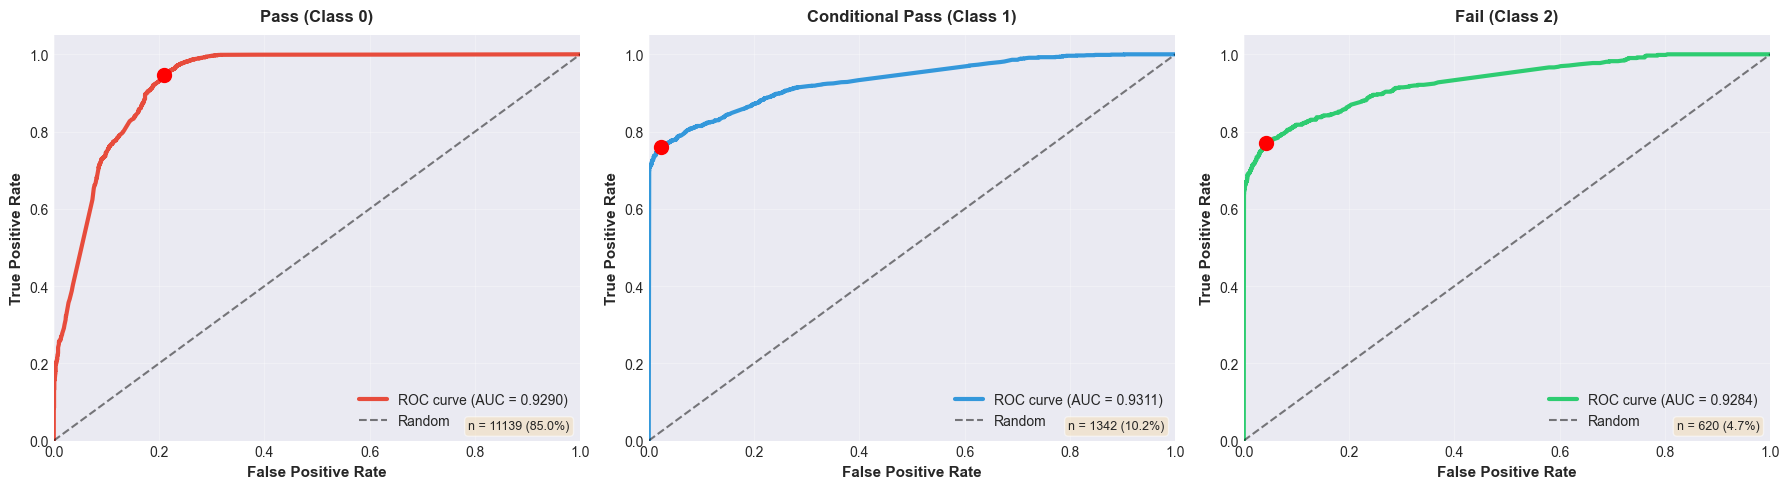


Individual class ROC curves saved as 'ROC_Individual_Classes.png'


In [15]:
# Create individual ROC curves for each class
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_names = ['Pass (Class 0)', 'Conditional Pass (Class 1)', 'Fail (Class 2)']
colors_individual = ['#e74c3c', '#3498db', '#2ecc71']

for i, (ax, name, color) in enumerate(zip(axes, class_names, colors_individual)):
    ax.plot(
        fpr[i], tpr[i], 
        color=color, 
        lw=3,
        label=f'ROC curve (AUC = {roc_auc[i]:.4f})'
    )
    ax.plot([0, 1], [0, 1], 'k--', lw=1.5, alpha=0.5, label='Random')
    
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=11, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=11, fontweight='bold')
    ax.set_title(f'{name}', fontsize=12, fontweight='bold', pad=10)
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Calculate and display optimal threshold point
    # Optimal point: maximize TPR - FPR
    optimal_idx = np.argmax(tpr[i] - fpr[i])
    optimal_threshold_fpr = fpr[i][optimal_idx]
    optimal_threshold_tpr = tpr[i][optimal_idx]
    
    ax.plot(
        optimal_threshold_fpr, optimal_threshold_tpr, 
        'ro', markersize=10, 
        label=f'Optimal point'
    )
    
    # Add text with class distribution
    class_count = (y_val == i).sum()
    class_pct = (y_val == i).mean() * 100
    ax.text(
        0.98, 0.02, 
        f'n = {class_count} ({class_pct:.1f}%)',
        transform=ax.transAxes,
        fontsize=9,
        verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )

plt.tight_layout()
plt.savefig('/Users/deepaktalwar/PyCharmMiscProject/outputs2/ROC_Individual_Classes.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nIndividual class ROC curves saved as 'ROC_Individual_Classes.png'")

## 14. Precision-Recall Analysis (Complementary to ROC)

AVERAGE PRECISION SCORES
  Class 0: 0.9820
  Class 1: 0.8317
  Class 2: 0.7698
  Micro-average: 0.9723


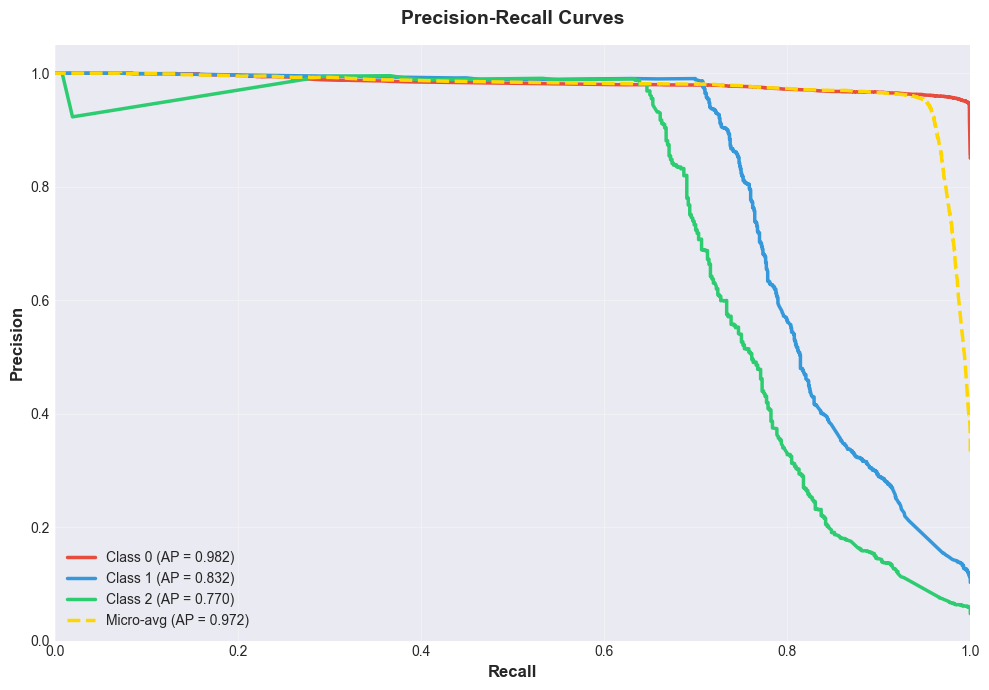


Precision-Recall curves saved as 'Precision_Recall_Curves.png'


In [16]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_val_bin[:, i], y_proba[:, i])
    average_precision[i] = average_precision_score(y_val_bin[:, i], y_proba[:, i])

# Compute micro-average
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_val_bin.ravel(), y_proba.ravel()
)
average_precision["micro"] = average_precision_score(
    y_val_bin, y_proba, average="micro"
)

print("="*70)
print("AVERAGE PRECISION SCORES")
print("="*70)
for i in range(n_classes):
    print(f"  Class {i}: {average_precision[i]:.4f}")
print(f"  Micro-average: {average_precision['micro']:.4f}")

# Plot Precision-Recall curves
fig, ax = plt.subplots(figsize=(10, 7))

colors = cycle(['#e74c3c', '#3498db', '#2ecc71'])
for i, color in zip(range(n_classes), colors):
    ax.plot(
        recall[i], precision[i], 
        color=color, 
        lw=2.5,
        label=f'Class {i} (AP = {average_precision[i]:.3f})'
    )

ax.plot(
    recall["micro"], precision["micro"],
    color='gold', 
    linestyle='--', 
    lw=2.5,
    label=f'Micro-avg (AP = {average_precision["micro"]:.3f})'
)

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc="lower left", fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/Users/deepaktalwar/PyCharmMiscProject/outputs2/Precision_Recall_Curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPrecision-Recall curves saved as 'Precision_Recall_Curves.png'")

## 15. Save Model and Metrics

In [17]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f'xgboost_multiclass_model_{timestamp}.pkl'
scaler_filename = f'scaler_{timestamp}.pkl'
metrics_filename = f'model_metrics_{timestamp}.pkl'

# Save model and scaler
joblib.dump(xgb_tuned, model_filename)
joblib.dump(scaler, scaler_filename)

# Create comprehensive metrics dictionary
metrics_dict = {
    # Model metadata
    'timestamp': timestamp,
    'model_type': 'XGBoost Multiclass',
    'best_params': best_params,
    
    # Dataset info
    'n_features': X.shape[1],
    'n_classes': n_classes,
    'train_size': len(X_train),
    'val_size': len(X_val),
    'class_distribution': y_train.value_counts().to_dict(),
    
    # Overall performance metrics
    'accuracy': tuned_accuracy,
    'macro_f1': f1_score(y_val, y_pred_tuned, average='macro'),
    'weighted_f1': f1_score(y_val, y_pred_tuned, average='weighted'),
    'macro_precision': precision_score(y_val, y_pred_tuned, average='macro'),
    'weighted_precision': precision_score(y_val, y_pred_tuned, average='weighted'),
    'macro_recall': recall_score(y_val, y_pred_tuned, average='macro'),
    'weighted_recall': recall_score(y_val, y_pred_tuned, average='weighted'),
    
    # ROC-AUC scores
    'roc_auc_per_class': {i: roc_auc[i] for i in range(n_classes)},
    'roc_auc_micro': roc_auc['micro'],
    'roc_auc_macro': roc_auc['macro'],
    'roc_auc_weighted': weighted_auc,
    
    # ROC curve data (for plotting later)
    'roc_curves': {
        'fpr': {i: fpr[i].tolist() for i in range(n_classes)},
        'tpr': {i: tpr[i].tolist() for i in range(n_classes)},
        'fpr_micro': fpr['micro'].tolist(),
        'tpr_micro': tpr['micro'].tolist(),
        'fpr_macro': fpr['macro'].tolist(),
        'tpr_macro': tpr['macro'].tolist()
    },
    
    # Average Precision scores
    'avg_precision_per_class': {i: average_precision[i] for i in range(n_classes)},
    'avg_precision_micro': average_precision['micro'],
    
    # Precision-Recall curve data
    'pr_curves': {
        'precision': {i: precision[i].tolist() for i in range(n_classes)},
        'recall': {i: recall[i].tolist() for i in range(n_classes)},
        'precision_micro': precision['micro'].tolist(),
        'recall_micro': recall['micro'].tolist()
    },
    
    # Per-class metrics
    'per_class_metrics': {},
    
    # Confusion matrix
    'confusion_matrix': confusion_matrix(y_val, y_pred_tuned).tolist(),
    
    # Classification report as dict
    'classification_report': classification_report(
        y_val, y_pred_tuned, 
        target_names=['Class 0', 'Class 1', 'Class 2'],
        output_dict=True
    )
}

# Add per-class accuracy
for i in range(n_classes):
    mask = y_val == i
    metrics_dict['per_class_metrics'][f'class_{i}_accuracy'] = accuracy_score(
        y_val[mask], y_pred_tuned[mask]
    )

# Save metrics dictionary
joblib.dump(metrics_dict, metrics_filename)

print(f"Model saved as: {model_filename}")
print(f"Scaler saved as: {scaler_filename}")
print(f"Metrics saved as: {metrics_filename}")
print(f"\n All files saved successfully with timestamp: {timestamp}")

Model saved as: xgboost_multiclass_model_20260115_000350.pkl
Scaler saved as: scaler_20260115_000350.pkl
Metrics saved as: model_metrics_20260115_000350.pkl

 All files saved successfully with timestamp: 20260115_000350


## 16. Load and Inspect Saved Metrics (Example)

In [ ]:
# Example: How to load and use the saved metrics
# loaded_metrics = joblib.load(metrics_filename)

# print("Loaded ROC-AUC Scores:")
# print(f"  Per-class: {loaded_metrics['roc_auc_per_class']}")
# print(f"  Macro: {loaded_metrics['roc_auc_macro']:.4f}")
# print(f"  Micro: {loaded_metrics['roc_auc_micro']:.4f}")
# print(f"  Weighted: {loaded_metrics['roc_auc_weighted']:.4f}")

print("\n Load metrics using: metrics = joblib.load('model_metrics_<timestamp>.pkl')")

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Load model and scaler
model = joblib.load(model_filename)
scaler = joblib.load("C:\\Users\\lkneh\\HealthScore-Predictor\\notebooks\\Model\\scaler_20260115_000350.pkl")  # adjust name

# Build a single-row DataFrame with SAME columns and order as X
sample = pd.DataFrame([{
    name: some_value_for_that_feature
    for name in feature_names
}])[feature_names]

# Scale and predict
sample_scaled = scaler.transform(sample)
proba = model.predict_proba(sample_scaled)   # shape (1, 3)
pred_class = model.predict(sample_scaled)  


Loaded model type: <class 'xgboost.sklearn.XGBClassifier'>

Loaded model parameters: {'objective': 'multi:softprob', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.9, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'mlogloss', 'feature_types': None, 'feature_weights': None, 'gamma': 0.1, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': 5, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.9, 'tree_method': None, 'validate_parameters': None, 'verbosity': None

## 17. Comprehensive Model Visualizations

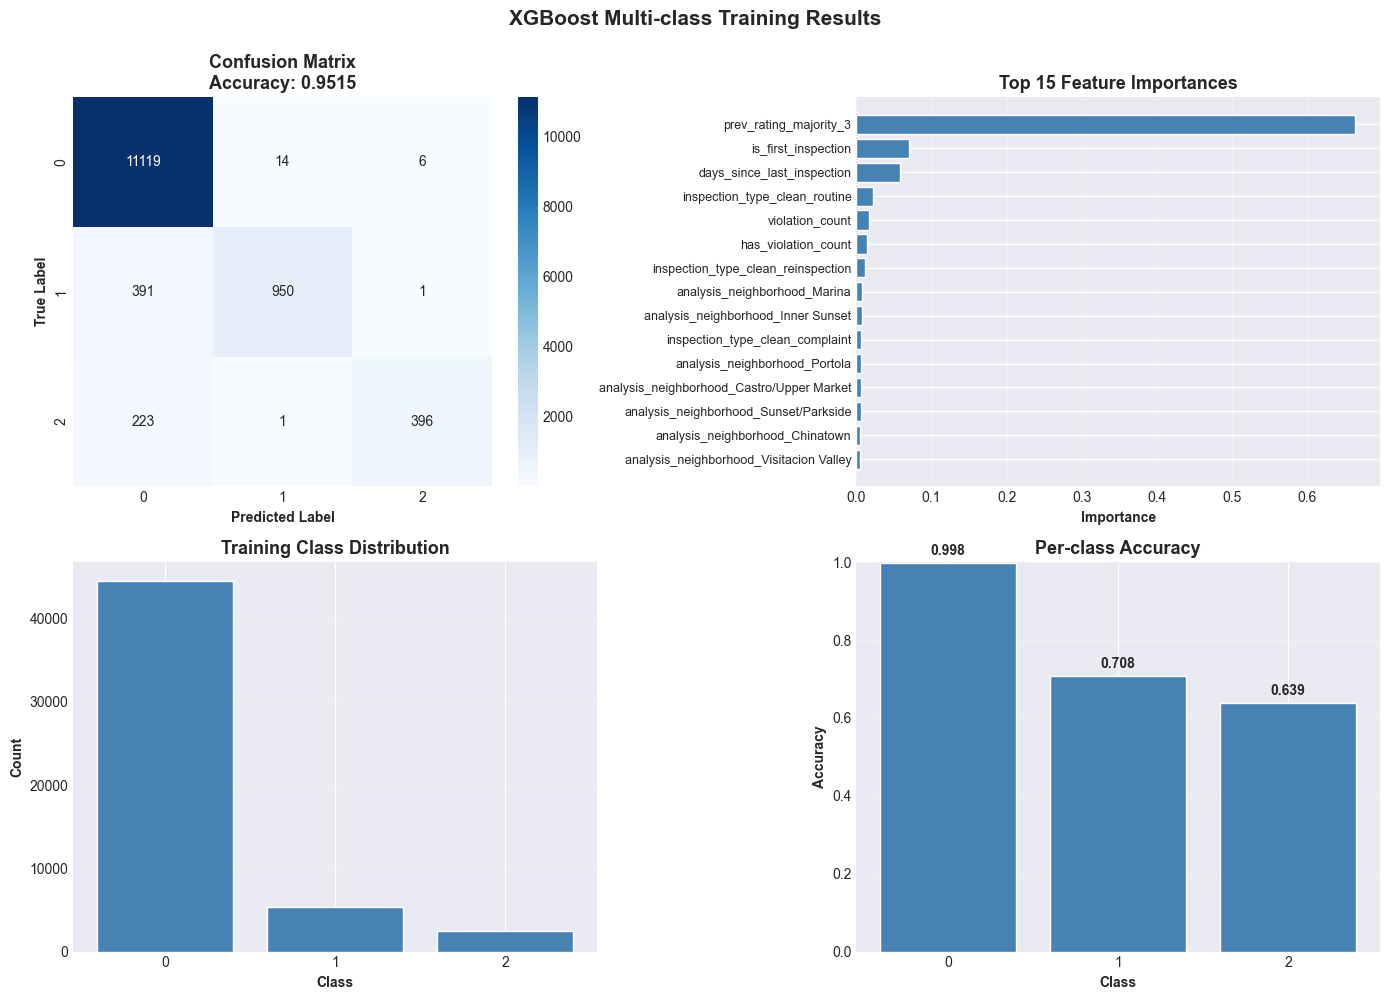

Visualization saved: XGBoost_Multiclass_Results.png


In [18]:
# Create comprehensive 2x2 visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred_tuned)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
axes[0, 0].set_title(f'Confusion Matrix\nAccuracy: {tuned_accuracy:.4f}', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('True Label', fontweight='bold')
axes[0, 0].set_xlabel('Predicted Label', fontweight='bold')

# Feature Importance
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)[-15:]
feature_names = X.columns.tolist()

axes[0, 1].barh(range(len(indices)), importances[indices], color='steelblue')
axes[0, 1].set_yticks(range(len(indices)))
axes[0, 1].set_yticklabels([feature_names[i] for i in indices], fontsize=9)
axes[0, 1].set_xlabel('Importance', fontweight='bold')
axes[0, 1].set_title('Top 15 Feature Importances', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

# Class Distribution
class_dist = y_train.value_counts().sort_index()
axes[1, 0].bar(class_dist.index, class_dist.values, color='steelblue')
axes[1, 0].set_xlabel('Class', fontweight='bold')
axes[1, 0].set_ylabel('Count', fontweight='bold')
axes[1, 0].set_title('Training Class Distribution', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks([0, 1, 2])
axes[1, 0].grid(axis='y', alpha=0.3)

# Per-class Accuracy
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
per_class_acc = np.diag(cm_normalized)
axes[1, 1].bar([0, 1, 2], per_class_acc, color='steelblue')
axes[1, 1].set_xlabel('Class', fontweight='bold')
axes[1, 1].set_ylabel('Accuracy', fontweight='bold')
axes[1, 1].set_title('Per-class Accuracy', fontsize=13, fontweight='bold')
axes[1, 1].set_ylim([0, 1])
axes[1, 1].set_xticks([0, 1, 2])
axes[1, 1].grid(axis='y', alpha=0.3)

for i, acc in enumerate(per_class_acc):
    axes[1, 1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontweight='bold')

plt.suptitle('XGBoost Multi-class Training Results', fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('XGBoost_Multiclass_Results.png', dpi=300, bbox_inches='tight')
plt.show()

print("Visualization saved: XGBoost_Multiclass_Results.png")

## 18. Model Summary

In [19]:
print("="*70)
print("MODEL PERFORMANCE SUMMARY")
print("="*70)

print("\nOverall Metrics:")
print(f"  Accuracy: {tuned_accuracy:.4f}")
print(f"  Macro F1-Score: {f1_score(y_val, y_pred_tuned, average='macro'):.4f}")
print(f"  Weighted F1-Score: {f1_score(y_val, y_pred_tuned, average='weighted'):.4f}")

print("\nROC-AUC Scores:")
for i in range(n_classes):
    print(f"  Class {i}: {roc_auc[i]:.4f}")
print(f"  Macro-average: {roc_auc['macro']:.4f}")
print(f"  Micro-average: {roc_auc['micro']:.4f}")
print(f"  Weighted-average: {weighted_auc:.4f}")

print("\nAverage Precision Scores:")
for i in range(n_classes):
    print(f"  Class {i}: {average_precision[i]:.4f}")
print(f"  Micro-average: {average_precision['micro']:.4f}")

print("\n Per-Class Performance:")
for i in range(n_classes):
    mask = y_val == i
    class_accuracy = accuracy_score(y_val[mask], y_pred_tuned[mask])
    print(f"  Class {i} Accuracy: {class_accuracy:.4f}")

print("\n" + "="*70)

MODEL PERFORMANCE SUMMARY

Overall Metrics:
  Accuracy: 0.9515
  Macro F1-Score: 0.8567
  Weighted F1-Score: 0.9477

ROC-AUC Scores:
  Class 0: 0.9290
  Class 1: 0.9311
  Class 2: 0.9284
  Macro-average: 0.9295
  Micro-average: 0.9842
  Weighted-average: 0.9292

Average Precision Scores:
  Class 0: 0.9820
  Class 1: 0.8317
  Class 2: 0.7698
  Micro-average: 0.9723

 Per-Class Performance:
  Class 0 Accuracy: 0.9982
  Class 1 Accuracy: 0.7079
  Class 2 Accuracy: 0.6387

